### Initial package imports

In [3]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt

## Initial files being read in and dataset creation

In [4]:
pd.set_option('display.float_format', '{:.6f}'.format)
# Read the data
main_df = pd.read_csv('Data/Cleaned_Indices_Assignment1.csv', sep=';')

# Read the interest rate data
#interest_rate_df = pd.read_csv('Data/ECB_Rates_2012_to_2022.csv', sep=';')
interest_rate_bond_df = pd.read_csv('Data/ECB_Data_10yr_Treasury_bond.csv', sep=',')

# Convert date columns to datetime format for proper merging
main_df['Date'] = pd.to_datetime(main_df['Date'], format='%d-%m-%Y')
#interest_rate_df['Date'] = pd.to_datetime(interest_rate_df['Date'], format='%d-%m-%Y')
#gov_bond_investment_df['Date'] = pd.to_datetime(gov_bond_investment_df['Date'], format='%Y-%m-%d')
interest_rate_bond_df['Date'] = pd.to_datetime(interest_rate_bond_df['Date'], format='%Y-%m-%d')

# Merge the dataframes on the Date column
main_df = pd.merge(main_df, interest_rate_bond_df, on='Date', how='left')
#main_df = pd.merge(main_df, gov_bond_investment_df, on='Date', how='left')

# Remove rows where the bond does not have a yield curve spot rate (Market closed?)
main_df = main_df.dropna(axis=0, subset=['Yield curve spot rate, 10-year maturity - Government bond'])

# Filter the dataframe to start from 2012-01-04
main_df = main_df[main_df['Date'] >= '2012-01-04']
main_df = main_df.reset_index(drop=True)

### government bond column

In [5]:
	
# Add a column for the interest bond value per day
days_per_annum = 365
interest_bond = 1500000

# Initialize the arrays with appropriate lengths matching the DataFrame
interest_bond_vector = np.zeros(len(main_df))
interest_bond_profit_vector = np.zeros(len(main_df))
interest_bond_loss_vector = np.zeros(len(main_df))
daily_rates = np.zeros(len(main_df))

# Set initial value
interest_bond_vector[0] = interest_bond


# Calculate bond values day by day based on the daily yield rate
for i in range(len(main_df)):
    # Adding 1.5% to account for the credit risk spread
    daily_rate = (((main_df['Yield curve spot rate, 10-year maturity - Government bond'].iloc[i] + 1.5) / (days_per_annum)) * (7/5)) / 100
    daily_rates[i] = daily_rate
    
    if i > 0:
        previous_value = interest_bond_vector[i-1]
        current_value = previous_value * (1 + daily_rate)
        interest_bond_vector[i] = current_value
        
        # Calculate change, profit/loss and return
        change = current_value - previous_value
        interest_bond_profit_vector[i] = change
        interest_bond_loss_vector[i] = -change

# Add vectors to the dataframe
main_df['Interest_Bond'] = interest_bond_vector
main_df['Interest_Bond_Profit'] = interest_bond_profit_vector
main_df['Interest_Bond_Loss'] = interest_bond_loss_vector
main_df['Interest_Bond_daily_rate'] = daily_rates




## Portfolio details

### details

#### Instruments:
- **S&P500**
- **DAX40**
- **NIKKEI**
- **EU Government Bond (10-year maturity, AAA-rated)**

#### Invested amount:
- **10,000,000 EURO**

#### Period:
- **01/01/2012 - 31/12/2022**

#### Weights:
- **S&P500**: 0.4  
- **DAX40**: 0.3  
- **NIKKEI**: 0.15  
- **EU Government Bond**: 0.15  

#### Measures:
- **Value at Risk (VaR)**: 1, 5, 10 days  
- **Expected Shortfall (ES)**  



### weights and currency correction


In [6]:
# initial investment 
weights = {
    'S&P500': 0.4,
    'DAX40': 0.3,
    'NIKKEI': 0.15,
    'EU-BOND': 0.15,
}

starting_investment = 10000000  # 10 million euros
starting_date = '2012-01-04'

# Filter the main_df for the starting date
starting_row = main_df[main_df['Date'] == starting_date]

# Extract the exchange rates for the starting date
usd_to_eur = float(starting_row['USD/EUR'].iloc[0])
jpy_to_eur = float(starting_row['JPY/EUR'].iloc[0])

# Calculate the invested amounts
invested_amount_SP500 = starting_investment * weights['S&P500'] / usd_to_eur
invested_amount_DAX40 = starting_investment * weights['DAX40']
invested_amount_NIKKEI = starting_investment * weights['NIKKEI'] / jpy_to_eur
invested_amount_EU_BOND = starting_investment * weights['EU-BOND']

invested_amounts = [
    invested_amount_SP500, #in USD
    invested_amount_DAX40, #in EUR
    invested_amount_NIKKEI, #in JPY
    invested_amount_EU_BOND #in EUR
]

print(invested_amounts)

[5177993.527508091, 3000000.0, 148957298.90764648, 1500000.0]


### Returns Portfolio 

In [7]:
#create a column for the invested amount in the SP500 and multiply by the return of the next day 

main_df['SP500_Investment'] = invested_amount_SP500 * (1 + main_df['C_S&P500_Returns']).cumprod()
main_df['DAX40_Investment'] = invested_amount_DAX40 * (1 + main_df['C_Dax40_Returns']).cumprod()
main_df['NIKKEI_Investment'] = invested_amount_NIKKEI * (1 + main_df['C_Nikkei_Returns']).cumprod()
main_df['EU_BOND_Investment'] = main_df['Interest_Bond']

## Methods input values 

### time window

### Expected returns (daily) --> Action make into method with time window as input parameter

In [8]:
def calculate_expected_daily_returns(time_window, current_date):
    expected_returns = {
        'Date': current_date,
        'SP500_Mean_Return': time_window['C_S&P500_Returns'].mean(),
        'DAX40_Mean_Return': time_window['C_Dax40_Returns'].mean(),
        'NIKKEI_Mean_Return': time_window['C_Nikkei_Returns'].mean(),
        'EU_Bond_Mean_Return': time_window['Interest_Bond_Profit'].mean(),
        'Portfolio_Mean_Return': (
            weights['S&P500'] * time_window['C_S&P500_Returns'].mean() +
            weights['DAX40'] * time_window['C_Dax40_Returns'].mean() +
            weights['NIKKEI'] * time_window['C_Nikkei_Returns'].mean() +
            weights['EU-BOND'] * time_window['Interest_Bond_Profit'].mean()
        )
    }
    return expected_returns

In [9]:
# Create Portfolio_loss column as the sum of the 4 loss components
main_df['Portfolio_loss'] = (
    main_df['C_S&P500_Loss'] + 
    main_df['C_Dax40_Loss'] + 
    main_df['C_Nikkei_Loss'] + 
    main_df['Interest_Bond_Loss']
)

In [10]:
loss_values = main_df['Portfolio_loss'].values

# Calculate and print the minimum, maximum, and mean of portfolio loss values
min_loss = np.nanmin(loss_values)
max_loss = np.nanmax(loss_values)
mean_loss = np.nanmean(loss_values)

print(f"Portfolio Loss Statistics:")
print(f"Minimum Loss: {min_loss:.4f}")
print(f"Maximum Loss: {max_loss:.4f}")
print(f"Mean Loss: {mean_loss:.4f}")

# Also print the number of valid loss values (non-NaN)
valid_count = np.sum(~np.isnan(loss_values))
print(f"Number of valid loss values: {valid_count} out of {len(loss_values)}")

Portfolio Loss Statistics:
Minimum Loss: -1249.7677
Maximum Loss: 1461.1150
Mean Loss: -146.1673
Number of valid loss values: 2804 out of 2805


In [11]:
def calculate_daily_loss_variables(time_window, current_date):
    # Calculate the mean and standard deviation of portfolio loss from the time windows
    loss_dict = {
        "Date": current_date,
        "Portfolio_mean_loss": np.nanmean(time_window['Portfolio_loss']),
        "Portfolio_std_loss": np.nanstd(time_window['Portfolio_loss'])
    }
    return loss_dict

### Variances --> Action make into method with time window as input parameter

### Covariance matrix --> action make into method with variable time window

### Portfolio variance & standard deviation

In [12]:
def calculate_variance_return(window, current_date, weights):
    """
    Calculate the variance returns for each index and the portfolio variance and volatility.
    """
    variance_return = {
        'Date': current_date,
        'SP500_Var_Return': window['C_S&P500_Returns'].var(),
        'DAX40_Var_Return': window['C_Dax40_Returns'].var(),
        'NIKKEI_Var_Return': window['C_Nikkei_Returns'].var(),
        'EU_Bond_Var_Return': window['Interest_Bond_daily_rate'].var()
    }

    weights = np.array([weights['S&P500'], weights['DAX40'], weights['NIKKEI'], weights['EU-BOND']])

    # Calculate the covariance matrix for the returns in the window
    covariance_matrix = window[['C_S&P500_Returns', 'C_Dax40_Returns', 'C_Nikkei_Returns', 'Interest_Bond_daily_rate']].cov()

    # Calculate the portfolio variance using the covariance matrix and weights
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix.values, weights))
    portfolio_volatility = np.sqrt(portfolio_variance)

    # Add portfolio variance and volatility to the variance_return dictionary
    variance_return['Portfolio_Variance'] = portfolio_variance
    variance_return['Portfolio_Volatility'] = portfolio_volatility

    return variance_return

# Value at Risk (VaR)

In [13]:
def VaR(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the VaR of the normal model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional) double, degrees of freedom for student-t

    Return value:
        dVaR    double, VaR
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dVaR = r + s*dVaR0
    else:
        dVaR0= st.t.ppf(alpha, df= df)

        dS2t= df/(df-2)

        c = s / np.sqrt(dS2t)
        dVaR= r + c*dVaR0
    return dVaR

# Expected Shortfall (ES) 

In [14]:
def ES(alpha, r= 0, s= 1, df= 0):
    """
    Purpose:
        Get the ES of the normal/student model

    Inputs:
        alpha   double, level
        r       double, expected return
        s       double, volatility
        df      (optional, default= 0/normal) double, df

    Return value:
        dES     double, ES
    """
    if (df == 0):
        dVaR0= st.norm.ppf(alpha)
        dES0= st.norm.pdf(dVaR0) / (1-alpha)
        dES= r + s*dES0
    else:
        dVaR0= st.t.ppf(alpha, df= df)
        dES0= st.t.pdf(dVaR0, df= df)*((df + dVaR0**2)/(df-1)) / (1-alpha)

        dS2t= df/(df-2)
        c= s / np.sqrt(dS2t)
        dES= r + c*dES0
    return dES

## performing different methods

write method for variance covariance where the sample period is an input parameter alongside other parameters that are needed for the calculation

## 1. var/cov multivar normal dist & T-distribution

4 code blocks with functions to calculate components of Var/cov method, 1 code block with for loop to iterate through set window for daily VaR and ES

## Main method

In [28]:
def main():
    # Initialize lists to store results
    mean_losses = []
    portfolio_std_losses = [] # Store standard dev of losses
    VaR_results = []
    ES_results = []  # List to store ES results
    time_window = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]

    vAlpha= [.95, .99]
    vAlpha= np.array(vAlpha)

    # Iterate through the DataFrame with a rolling window of 500 days
    sample_size = 500
    degrees_of_freedom = [0, 3, 4, 5, 6] # Normal (0) and T-distributions

    for i in range(sample_size, len(time_window)):
        # Extract the window of 500 days
        window = time_window.iloc[i - sample_size:i]
        current_date = time_window.iloc[i]['Date']
        
        # Calculate mean loss and portfolio std dev of LOSS
        loss_stats = calculate_daily_loss_variables(window, current_date)
        mean_loss = loss_stats["Portfolio_mean_loss"]
        portfolio_std_loss = loss_stats["Portfolio_std_loss"] # Use std dev of loss
        
        # Append the results to the lists
        mean_losses.append(mean_loss)
        portfolio_std_losses.append(portfolio_std_loss)
        
        # Dictionaries to hold results for the current date
        var_row = {'Date': current_date}
        es_row = {'Date': current_date}
        
        # Calculate VaR and ES for each degree of freedom using mean and std dev of LOSS
        for df in degrees_of_freedom:
            # Use portfolio_std_loss (std dev of loss) as 's' parameter
            current_var = VaR(vAlpha, mean_loss, portfolio_std_loss, df)
            current_es = ES(vAlpha, mean_loss, portfolio_std_loss, df)
            
            # Determine the key name (e.g., 'VaR Normal', 'VaR T3')
            var_key = f"VaR {'Normal' if df == 0 else f'T{df}'}"
            es_key = f"ES {'Normal' if df == 0 else f'T{df}'}"
            
            # Add to the row dictionaries
            var_row[var_key] = current_var
            es_row[es_key] = current_es

        # Historical simulation
        # Extract the portfolio loss values from the window
        historical_losses = window['Portfolio_loss'].dropna()  # Remove NaN values directly
        
        # Sort the losses in ascending order
        sorted_losses = np.sort(historical_losses)

        # Calculate VaR for alpha levels
        var_95 = np.percentile(sorted_losses, 95) 
        var_99 = np.percentile(sorted_losses, 99)  

        # Calculate ES
        es_95 = sorted_losses[sorted_losses >= var_95].mean()  # Mean of losses below VaR 95
        es_99 = sorted_losses[sorted_losses >= var_99].mean()  # Mean of losses below VaR 99

        # Add to the row dictionaries
        var_row['VaR Historical 95%'] = var_95
        var_row['VaR Historical 99%'] = var_99
        es_row['ES Historical 95%'] = es_95
        es_row['ES Historical 99%'] = es_99
        

        # Append the dictionaries to the results lists
        VaR_results.append(var_row)
        ES_results.append(es_row)



    # Convert the results to DataFrames for easier analysis
    mean_losses_df = pd.DataFrame(mean_losses, columns=['Mean_Loss'])
    portfolio_std_losses_df = pd.DataFrame(portfolio_std_losses, columns=['Portfolio_Std_Loss']) # New DataFrame for std dev of loss
    var_results_df = pd.DataFrame(VaR_results)
    es_results_df = pd.DataFrame(ES_results)

    # Return all relevant DataFrames
    return mean_losses_df, portfolio_std_losses_df, var_results_df, es_results_df

In [30]:
# Unpack the returned DataFrames
mean_loss_df, portfolio_std_losses_df, var_results_df, es_results_df = main()

print("VaR Results Head:")
display(var_results_df.head())
print("\nES Results Head:")
display(es_results_df.head())

VaR Results Head:


,Date,VaR Normal,VaR T3,VaR T4,VaR T5,VaR T6,VaR Historical 95%,VaR Historical 99%
0,2013-12-17,"[-82.30119675585965, -25.34968326982161]","[-106.21339737183416, -0.6778835093051896]","[-93.7843824706223, 1.6550079916029006]","[-89.32128163008665, -1.9408095058245465]","[-87.16936562634834, -5.324130939808867]",-67.051316,-1.160570
1,2013-12-18,"[-82.15727819508106, -25.211726053695116]","[-106.06697582455816, -0.5425087899826906]","[-93.63926191847314, 1.7901385177614486]","[-89.17662824870607, -1.8053025909434552]","[-87.02493749469645, -5.188269879025398]",-67.192861,-1.237993
2,2013-12-19,"[-82.08118389286349, -25.01298534373626]","[-106.04237700204295, -0.2906367859119996]","[-93.5878969235406, 2.047034457891442]","[-89.11565186239912, -1.5561503273543735]","[-86.95932690726886, -4.946403676766607]",-67.192861,-1.237993
3,2013-12-20,"[-81.93241326759355, -24.657514429308094]","[-105.98039351339482, 0.15437816048998343]","[-93.48080346648639, 2.5005164198000784]","[-88.99235999062662, -1.11571905490041]","[-86.82822485394033, -4.518251858815489]",-67.192861,-1.237993
4,2013-12-23,"[-82.00214760685154, -24.681659770267316]","[-106.06926928027208, 0.14998229708567123]","[-93.55972995713721, 2.497988007849756]","[-89.06771382299021, -1.1211258753027664]","[-86.90185610354837, -4.526366987139028]",-67.192861,-1.237993



ES Results Head:


,Date,ES Normal,ES T3,ES T4,ES T5,ES T6,ES Historical 95%,ES Historical 99%
0,2013-12-17,"[-47.38129411788998, 2.9688995707182926]","[-32.832287796697074, 118.12784415501622]","[-30.495544020028433, 88.73503163312867]","[-32.67560828984665, 68.45513049403243]","[-34.79620206739733, 55.394053690153925]",-21.358298,37.238362
1,2013-12-18,"[-47.241030764183165, 3.1038925665451416]","[-32.69354734617082, 118.25078299957619]","[-30.357048165899414, 88.86104714194238]","[-32.53688423959636, 68.58326878190508]","[-34.657256046042164, 55.52355913362237]",-21.358298,37.238362
2,2013-12-19,"[-47.08973564016, 3.3636180027232285]","[-32.51092059894265, 118.75850589900003]","[-30.169389186646526, 89.30547193656506]","[-32.35392007940928, 68.98402033815685]","[-34.47885863383374, 55.89618335746147]",-21.358298,37.238362
3,2013-12-20,"[-46.81422643445859, 3.821868613482451]","[-32.1826071106247, 119.63471532573632]","[-29.83259470134078, 90.0750028489729]","[-32.02503793720683, 69.67994721139237]","[-34.157672992043274, 56.544706251648364]",-21.358298,37.238362
4,2013-12-23,"[-46.8560078136544, 3.8203919558631014]","[-32.21274218608204, 119.72542201158561]","[-29.860859241643908, 90.1421809436043]","[-32.05504759261237, 69.73089149024011]","[-34.18938015714079, 56.5851952963549]",-21.358298,37.238362


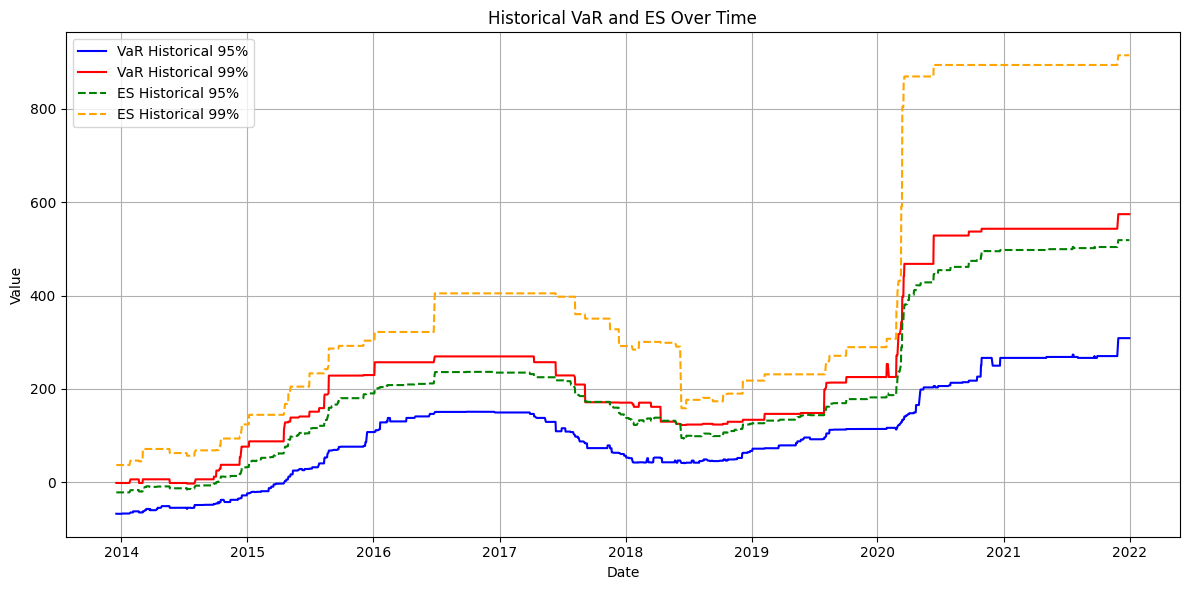

In [31]:
# Plot Historical VaR and ES over time
plt.figure(figsize=(12, 6))

# Plot VaR Historical 95% and 99%
plt.plot(var_results_df['Date'], var_results_df['VaR Historical 95%'], label='VaR Historical 95%', color='blue')
plt.plot(var_results_df['Date'], var_results_df['VaR Historical 99%'], label='VaR Historical 99%', color='red')

# Plot ES Historical 95% and 99%
plt.plot(es_results_df['Date'], es_results_df['ES Historical 95%'], label='ES Historical 95%', color='green', linestyle='--')
plt.plot(es_results_df['Date'], es_results_df['ES Historical 99%'], label='ES Historical 99%', color='orange', linestyle='--')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Historical VaR and ES Over Time')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Create subplots for all indices
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# S&P 500
sp500_returns = main_df['C_S&P500_Returns'].dropna()
mu_sp500 = sp500_returns.mean()
sigma_sp500 = sp500_returns.std()
x_sp500 = np.linspace(mu_sp500 - 4*sigma_sp500, mu_sp500 + 4*sigma_sp500, 100)
ax1.hist(sp500_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax1.plot(x_sp500, st.norm.pdf(x_sp500, mu_sp500, sigma_sp500), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_sp500 / np.sqrt(df/(df-2))
    ax1.plot(x_sp500, st.t.pdf((x_sp500-mu_sp500)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax1.set_title('S&P500 Returns Distribution')
ax1.legend()
ax1.grid(True)

# DAX40
dax_returns = main_df['C_Dax40_Returns'].dropna()
mu_dax = dax_returns.mean()
sigma_dax = dax_returns.std()
x_dax = np.linspace(mu_dax - 4*sigma_dax, mu_dax + 4*sigma_dax, 100)
ax2.hist(dax_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax2.plot(x_dax, st.norm.pdf(x_dax, mu_dax, sigma_dax), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_dax / np.sqrt(df/(df-2))
    ax2.plot(x_dax, st.t.pdf((x_dax-mu_dax)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax2.set_title('DAX40 Returns Distribution')
ax2.legend()
ax2.grid(True)

# NIKKEI
nikkei_returns = main_df['C_Nikkei_Returns'].dropna()
mu_nikkei = nikkei_returns.mean()
sigma_nikkei = nikkei_returns.std()
x_nikkei = np.linspace(mu_nikkei - 4*sigma_nikkei, mu_nikkei + 4*sigma_nikkei, 100)
ax3.hist(nikkei_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax3.plot(x_nikkei, st.norm.pdf(x_nikkei, mu_nikkei, sigma_nikkei), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_nikkei / np.sqrt(df/(df-2))
    ax3.plot(x_nikkei, st.t.pdf((x_nikkei-mu_nikkei)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax3.set_title('NIKKEI Returns Distribution')
ax3.legend()
ax3.grid(True)

# EU Bond
bond_returns = main_df['Interest_Bond_daily_rate'].dropna()
mu_bond = bond_returns.mean()
sigma_bond = bond_returns.std()
x_bond = np.linspace(mu_bond - 4*sigma_bond, mu_bond + 4*sigma_bond, 100)
ax4.hist(bond_returns, bins=500, density=True, alpha=0.3, color='grey', label='Histogram')
ax4.plot(x_bond, st.norm.pdf(x_bond, mu_bond, sigma_bond), 'r-', lw=2, label='Normal')
# Add t-distributions
for df in [3, 4, 5, 6]:
    s = sigma_bond / np.sqrt(df/(df-2))
    ax4.plot(x_bond, st.t.pdf((x_bond-mu_bond)/s, df)/s, '--', lw=1, label=f't-dist (df={df})')
ax4.set_title('EU Bond Returns Distribution')
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()

## Historical simulation

VaR (S&P500) at 95.0% confidence level: 31.027729599999944
ES (S&P500) at 95.0% confidence level: 59.257054484375004


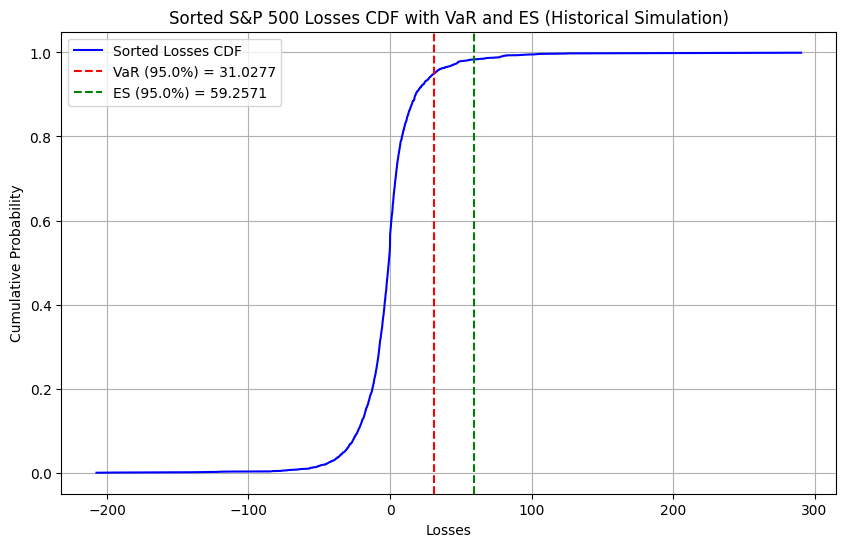

In [ ]:
# Define the confidence level
confidence_level = 0.95

# Extract historical losses for S&P500 for the specified period
sp500_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_S&P500_Loss']

# Sort the losses in ascending order (smallest loss first, largest loss last)
sorted_losses = sp500_losses.sort_values()

# Calculate VaR at the specified confidence level
# This finds the value at the threshold separating the worst (1-confidence_level)% losses
VaR_sp500 = sorted_losses.quantile(confidence_level)

# Calculate ES (Expected Shortfall)
# This is the average of the losses that are greater than or equal to the VaR value
tail_sp_losses = sorted_losses[sorted_losses >= VaR_sp500]
ES_sp500 = tail_sp_losses.mean()

print(f"VaR (S&P500) at {confidence_level * 100}% confidence level: {VaR_sp500}")
print(f"ES (S&P500) at {confidence_level * 100}% confidence level: {ES_sp500}")

# Plot the sorted losses (Empirical Cumulative Distribution Function - CDF)
plt.figure(figsize=(10, 6))
# Plotting the empirical CDF: x-axis is loss value, y-axis is cumulative probability
plt.plot(sorted_losses.values, np.linspace(0, 1, len(sorted_losses), endpoint=False), label='Sorted Losses CDF', color='blue')

# Highlight VaR and ES on the graph
# VaR is the loss value at the confidence level percentile
plt.axvline(x=VaR_sp500, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%) = {VaR_sp500:.4f}')
# ES is the average loss in the tail beyond VaR
plt.axvline(x=ES_sp500, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%) = {ES_sp500:.4f}')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Cumulative Probability')
plt.title('Sorted S&P 500 Losses CDF with VaR and ES (Historical Simulation)')
plt.legend()
plt.grid(True)
plt.show()

VaR (DAX40) at 95.0% confidence level: 199.3679999999997
ES (DAX40) at 95.0% confidence level: 314.866953125


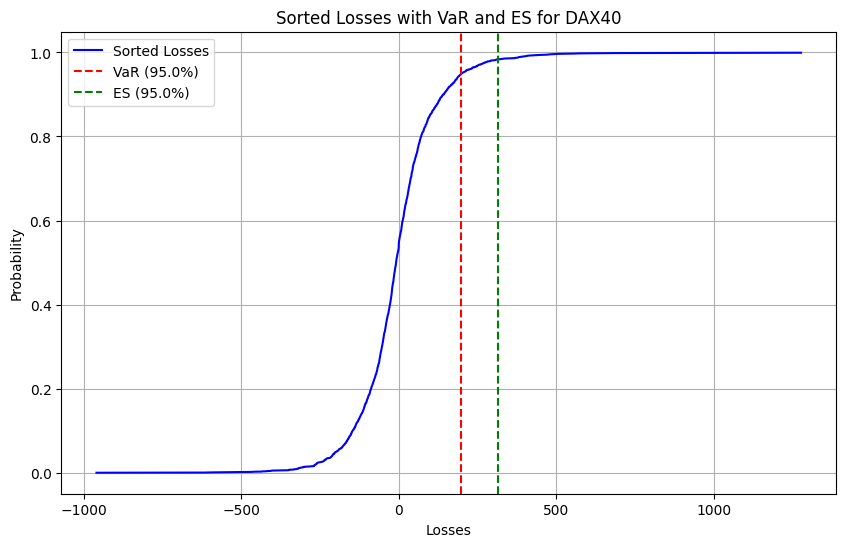

In [ ]:
confidence_level = 0.95
# Extract historical losses for DAX40
dax40_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Dax40_Loss']

# Sort the losses in ascending order
sorted_dax40_losses = dax40_losses.sort_values()

# Calculate VaR at the specified confidence level
# This finds the value at the threshold separating the worst (1-confidence_level)% losses
VaR_dax40 = sorted_dax40_losses.quantile(confidence_level)

# Calculate ES (Expected Shortfall)
# This is the average of the losses that are greater than or equal to the VaR value
tail_dax_losses = sorted_dax40_losses[sorted_dax40_losses >= VaR_dax40]
ES_dax40 = tail_dax_losses.mean()

print(f"VaR (DAX40) at {confidence_level * 100}% confidence level: {VaR_dax40}")
print(f"ES (DAX40) at {confidence_level * 100}% confidence level: {ES_dax40}")

# Plot the sorted losses as a line graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_dax40_losses.values, np.linspace(0, 1, len(sorted_dax40_losses), endpoint=False), label='Sorted Losses', color='blue')

# Highlight VaR and ES on the graph
plt.axvline(x=VaR_dax40, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
plt.axvline(x=ES_dax40, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Probability')
plt.title('Sorted Losses with VaR and ES for DAX40')
plt.legend()
plt.grid()
plt.show()

VaR (Nikkei) at 95.0% confidence level: 3.0092212339999986
ES (Nikkei) at 95.0% confidence level: 4.61174921890625


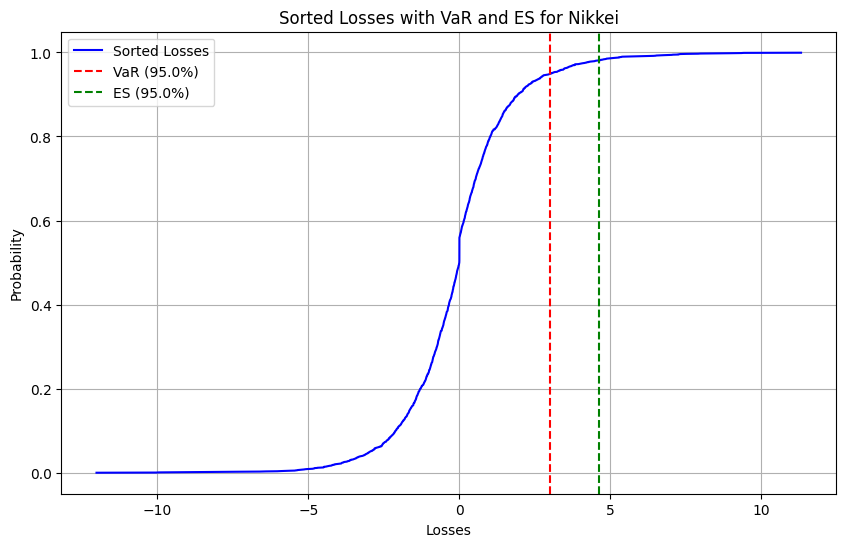

In [ ]:
confidence_level = 0.95

# Extract historical losses for Nikkei
nikkei_losses = main_df[(main_df['Date'] >= '2012-01-04') & (main_df['Date'] <= '2021-12-31')]['C_Nikkei_Loss']

# Sort the losses in ascending order
sorted_nikkei_losses = nikkei_losses.sort_values()

# Calculate VaR at the specified confidence level
# This finds the value at the threshold separating the worst (1-confidence_level)% losses
VaR_nikkei = sorted_nikkei_losses.quantile(confidence_level)

# Calculate ES (Expected Shortfall)
# This is the average of the losses that are greater than or equal to the VaR value
tail_nik_losses = sorted_nikkei_losses[sorted_nikkei_losses >= VaR_nikkei]
ES_nikkei = tail_nik_losses.mean()

print(f"VaR (Nikkei) at {confidence_level * 100}% confidence level: {VaR_nikkei}")
print(f"ES (Nikkei) at {confidence_level * 100}% confidence level: {ES_nikkei}")

# Plot the sorted losses as a line graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_nikkei_losses.values, np.linspace(0, 1, len(sorted_nikkei_losses), endpoint=False), label='Sorted Losses', color='blue')

# Highlight VaR and ES on the graph
plt.axvline(x=VaR_nikkei, color='red', linestyle='--', label=f'VaR ({confidence_level * 100}%)')
plt.axvline(x=ES_nikkei, color='green', linestyle='--', label=f'ES ({confidence_level * 100}%)')

# Add labels, title, and legend
plt.xlabel('Losses')
plt.ylabel('Probability')
plt.title('Sorted Losses with VaR and ES for Nikkei')
plt.legend()
plt.grid()
plt.show()